# Setup the directories

In [1]:
import os
base_dir = '/home/ayan/Documents/Computer Vision/Classification/Cat_Vs_Dog/cats_and_dogs_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Data Preprocessing using ImageDataGenerator
ImageDataGenerator converts image files into batches of preprocessed tensors
Note: A Python generator is an object that acts as an iterator

In [2]:
from keras.preprocessing.image import ImageDataGenerator

#Rescale all pixel values between 0 - 255 to (1, 0)
train_idg = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
test_idg = ImageDataGenerator(rescale = 1./255) #Validation images are not augmented

train_gen = train_idg.flow_from_directory(
    train_dir,
    target_size = (150, 150),       #resize images to (150, 150)
    batch_size = 20,                #32samples per batch i.e. shape = (32, 150, 150, 3)
    class_mode = 'binary'           #since this is a binary classification problem
)

valid_gen = test_idg.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Use a pretrained model

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

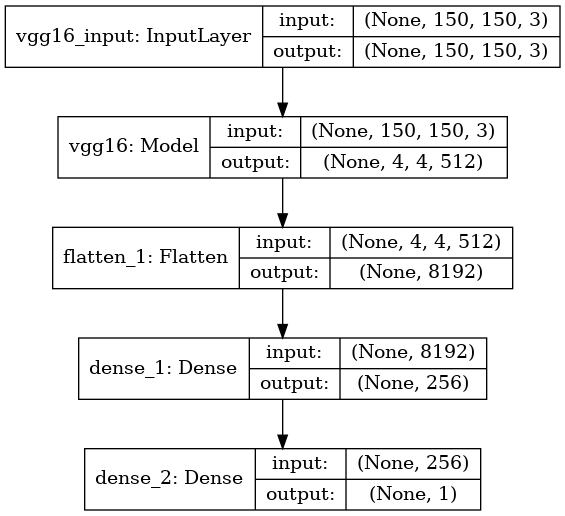

In [3]:
from keras.applications import VGG16
from keras.layers import Flatten, BatchNormalization, Dense
from keras.models import Sequential

vgg16_base = VGG16(weights = 'imagenet',
                       include_top = False,
                      input_shape = (150, 150, 3))  # input_shape is an optional parameter
vgg16_base.summary()
model = Sequential()
model.add(vgg16_base)

model.add(Flatten())
model.add(Dense(256, activation = 'relu')) 
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file = 'pretrained_vgg16.png')

# Setup & configure optimizers
Important to make the pretrained model base non-trainable. Otherwise it will be computationally expensive to train the entire model with millions of parameters

In [4]:
from keras import optimizers
from keras import losses
from keras import metrics

vgg16_base.trainable = False

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), # Try Adam
             loss = losses.binary_crossentropy,
             metrics = [metrics.binary_accuracy])

# Use batch generator
'steps_per_epoch' is for telling the fit_generator that it needs to run mentioned number of gradient descent steps before drawing the next epoch batch

'validation_steps' tells the process about number of batches to draw from the validation generator

In [5]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = valid_gen,
    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 11s 111ms/step - loss: 0.5876 - binary_accuracy: 0.6865 - val_loss: 0.3017 - val_binary_accuracy: 0.8510
Epoch 2/30
100/100 [==============================] - 9s 88ms/step - loss: 0.4777 - binary_accuracy: 0.7825 - val_loss: 0.4293 - val_binary_accuracy: 0.8560
Epoch 3/30
100/100 [==============================] - 9s 88ms/step - loss: 0.4246 - binary_accuracy: 0.8200 - val_loss: 0.2984 - val_binary_accuracy: 0.8770
Epoch 4/30
100/100 [==============================] - 9s 89ms/step - loss: 0.4013 - binary_accuracy: 0.8220 - val_loss: 0.2563 - val_binary_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 9s 89ms/step - loss: 0.3788 - binary_accuracy: 0.8335 - val_loss: 0.1861 - val_binary_accuracy: 0.8770
Epoch 6/30
100/100 [==============================] - 9s 89ms/step - loss: 0.3659 - binary_accuracy: 0.8490 - val_loss: 0.3023 - val_binary_accuracy: 0.8760
Epoch 7/30
100/100 [==============================] - 9s

# Display training vs validation 
This is a very curious case where Validation Accuracy is consistently higher than Training Accuracy.

Reason: By making the pretrained model base non-trainable I have reduced the network's ability to learn. On the other hand, during validation the network has the full capacity available to validate the validation images on the pretrained model. Considering I am working a quite small dataset this is not a very unexpected situation

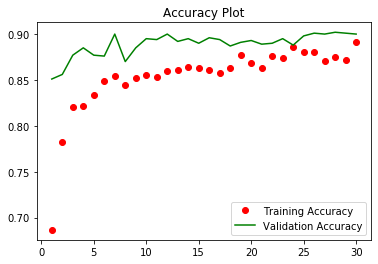

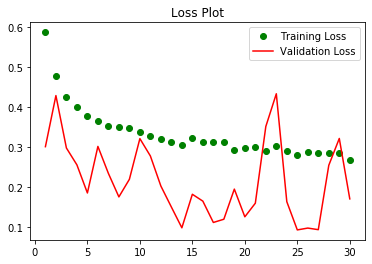

In [6]:
import matplotlib.pyplot as plt
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'ro', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'go', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()